In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from IPython.display import Image, display

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


In [108]:
CABIN_NUMBER_BINS = [0, 50, 90, np.inf]
CABIN_NUMBER_LABELS = ['1-50 (Нос)', '51-90 (Центр)', '91+ (Корма)']
FAMILY_SIZE_BINS = [-np.inf, 0, 2, np.inf]
FAMILY_SIZE_LABELS = ['0 (Один)', '1-2', '3+']
RARE_TITLE_THRESHOLD = 10
CV_FOLDS = 5
RANDOM_STATE = 42

In [110]:
# Загрузка данных
df = pd.read_csv('Titanic.csv')
print(f"Загружено данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Целевая переменная 'Survived': {df['Survived'].value_counts().to_dict()}")

Загружено данных: 891 строк, 12 столбцов
Целевая переменная 'Survived': {0: 549, 1: 342}


In [112]:
# ==================== 1. ПЕРВИЧНЫЙ АНАЛИЗ И ОБРАБОТКА ПРОПУСКОВ ====================
print("\n" + "="*60)
print("1. ПЕРВИЧНЫЙ АНАЛИЗ И ОБРАБОТКА ПРОПУСКОВ")
print("="*60)

# Анализ пропусков
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Количество': missing, 'Процент': missing_pct})
missing_df = missing_df[missing_df['Количество'] > 0].sort_values('Процент', ascending=False)
print("Пропущенные значения:")
print(missing_df.to_string())

# Обработка пропусков в 'Age' (медиана по классу и полу)
age_median = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
df['Age'] = df['Age'].fillna(age_median)
print(f"\nЗаполнено пропусков в 'Age': {missing['Age']}")

# Обработка пропусков в 'Embarked' (мода)
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(embarked_mode)
print(f"Заполнено пропусков в 'Embarked': {missing['Embarked']}")


1. ПЕРВИЧНЫЙ АНАЛИЗ И ОБРАБОТКА ПРОПУСКОВ
Пропущенные значения:
          Количество    Процент
Cabin            687  77.104377
Age              177  19.865320
Embarked           2   0.224467

Заполнено пропусков в 'Age': 177
Заполнено пропусков в 'Embarked': 2



2. АНАЛИЗ СЕМЕЙНЫХ ХАРАКТЕРИСТИК

2.1 Выживаемость в зависимости от количества родных на борту


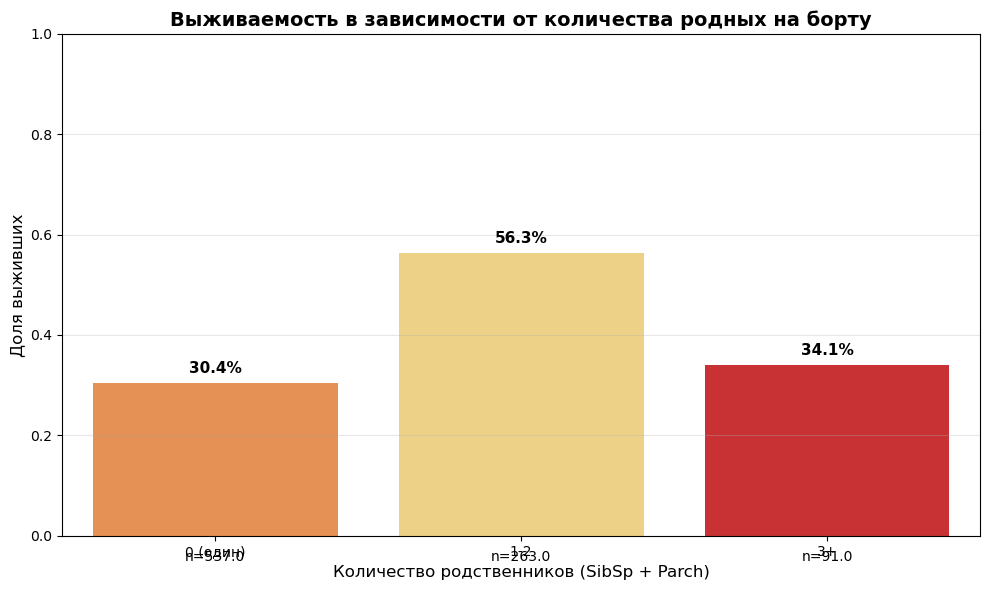


Вывод: Пассажиры с 1-2 родственниками имеют наибольшую выживаемость.

2.2 Средний возраст по количеству родственников на борту

📊 СРЕДНИЙ ВОЗРАСТ ПО КОЛИЧЕСТВУ РОДСТВЕННИКОВ НА БОРТУ:
              Средний_возраст  Количество
Всего_родных                             
0                        31.0         537
1                        30.8         161
2                        25.8         102
3                        18.6          29
4                        21.2          15
5                        18.4          22
6                        15.2          12
7                        15.7           6
10                       23.5           7


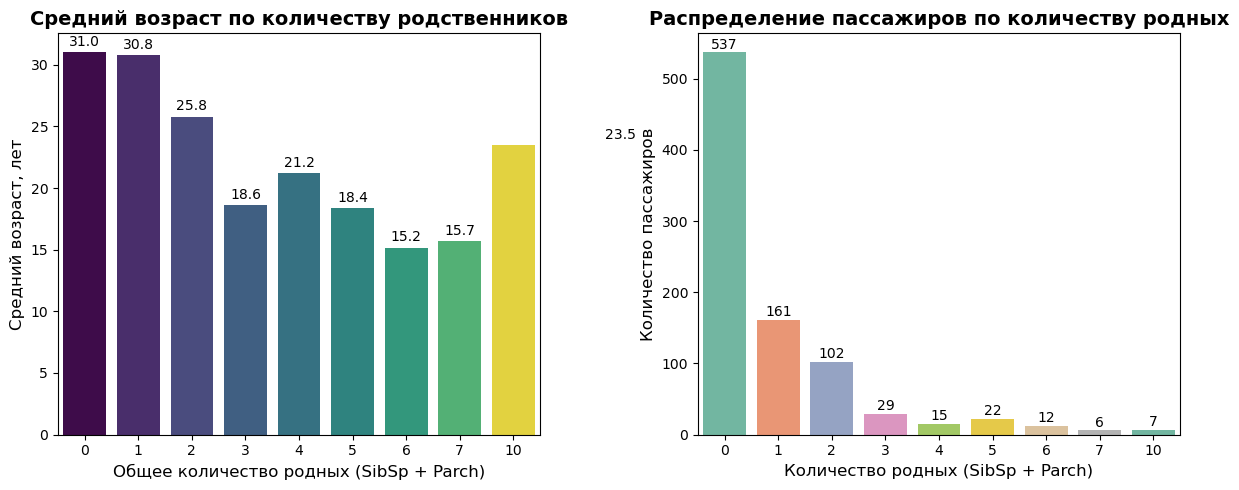


Вывод: Молодые пассажиры чаще путешествовали с родственниками.


In [114]:
# ==================== 2. АНАЛИЗ СЕМЕЙНЫХ ХАРАКТЕРИСТИК ====================
print("\n" + "="*60)
print("2. АНАЛИЗ СЕМЕЙНЫХ ХАРАКТЕРИСТИК")
print("="*60)

# ---- 2.1 Выживаемость по количеству родственников ----
print("\n2.1 Выживаемость в зависимости от количества родных на борту")

# Создаем столбец с общим количеством родственников
df['Всего_родных'] = df['SibSp'] + df['Parch']

# Группируем по количеству родных
df['Family_Group'] = df['Всего_родных'].apply(
    lambda x: '0 (один)' if x == 0 else ('1-2' if x <= 2 else '3+')
)

# Порядок групп
family_groups_order = ['0 (один)', '1-2', '3+']

# Создаем график
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Family_Group', y='Survived', hue='Family_Group',
            order=family_groups_order, palette='YlOrRd', legend=False, errorbar=None)

plt.title('Выживаемость в зависимости от количества родных на борту', 
          fontsize=14, fontweight='bold')
plt.xlabel('Количество родственников (SibSp + Parch)', fontsize=12)
plt.ylabel('Доля выживших', fontsize=12)
plt.ylim(0, 1)

# Статистика для подписей
family_stats = df.groupby('Family_Group', observed=False)['Survived'].agg(['mean', 'count'])

# Добавляем значения
for i, group in enumerate(family_groups_order):
    data = family_stats.loc[group]
    plt.text(i, data['mean'] + 0.02, f"{data['mean']:.1%}", 
             ha='center', fontsize=11, fontweight='bold')
    plt.text(i, -0.05, f"n={data['count']}", ha='center', fontsize=10)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nВывод: Пассажиры с 1-2 родственниками имеют наибольшую выживаемость.")

# ---- 2.2 Средний возраст по количеству родственников ----
print("\n2.2 Средний возраст по количеству родственников на борту")

# Статистика среднего возраста
age_by_relatives = df.groupby('Всего_родных', observed=False)['Age'].agg(['mean', 'count']).round(1)
age_by_relatives.columns = ['Средний_возраст', 'Количество']

print("\n📊 СРЕДНИЙ ВОЗРАСТ ПО КОЛИЧЕСТВУ РОДСТВЕННИКОВ НА БОРТУ:")
print("="*70)
print(age_by_relatives)

# График: Средний возраст по количеству родных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='Всего_родных', y='Age', hue='Всего_родных',
            palette='viridis', legend=False, errorbar=None)
plt.title('Средний возраст по количеству родственников', fontsize=14, fontweight='bold')
plt.xlabel('Общее количество родных (SibSp + Parch)', fontsize=12)
plt.ylabel('Средний возраст, лет', fontsize=12)

# Добавляем значения на столбцы
for i, row in age_by_relatives.iterrows():
    if not pd.isna(row['Средний_возраст']):
        plt.text(i, row['Средний_возраст'] + 0.5, f"{row['Средний_возраст']:.1f}", 
                 ha='center', fontsize=10)

# График 2: Количество пассажиров в каждой группе
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Всего_родных', hue='Всего_родных',
              palette='Set2', legend=False)
plt.title('Распределение пассажиров по количеству родных', fontsize=14, fontweight='bold')
plt.xlabel('Количество родных (SibSp + Parch)', fontsize=12)
plt.ylabel('Количество пассажиров', fontsize=12)

# Добавляем значения
for i, count in enumerate(age_by_relatives['Количество']):
    plt.text(i, count + 5, str(int(count)), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nВывод: Молодые пассажиры чаще путешествовали с родственниками.")

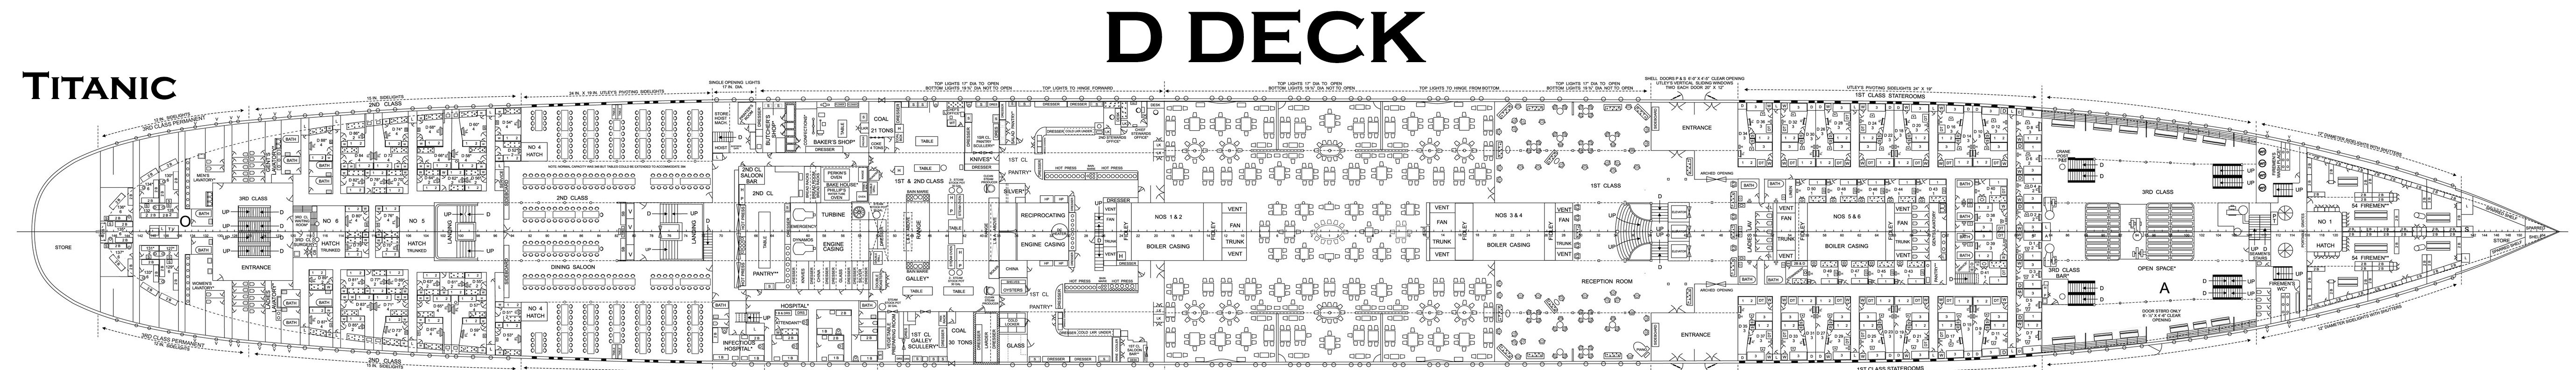

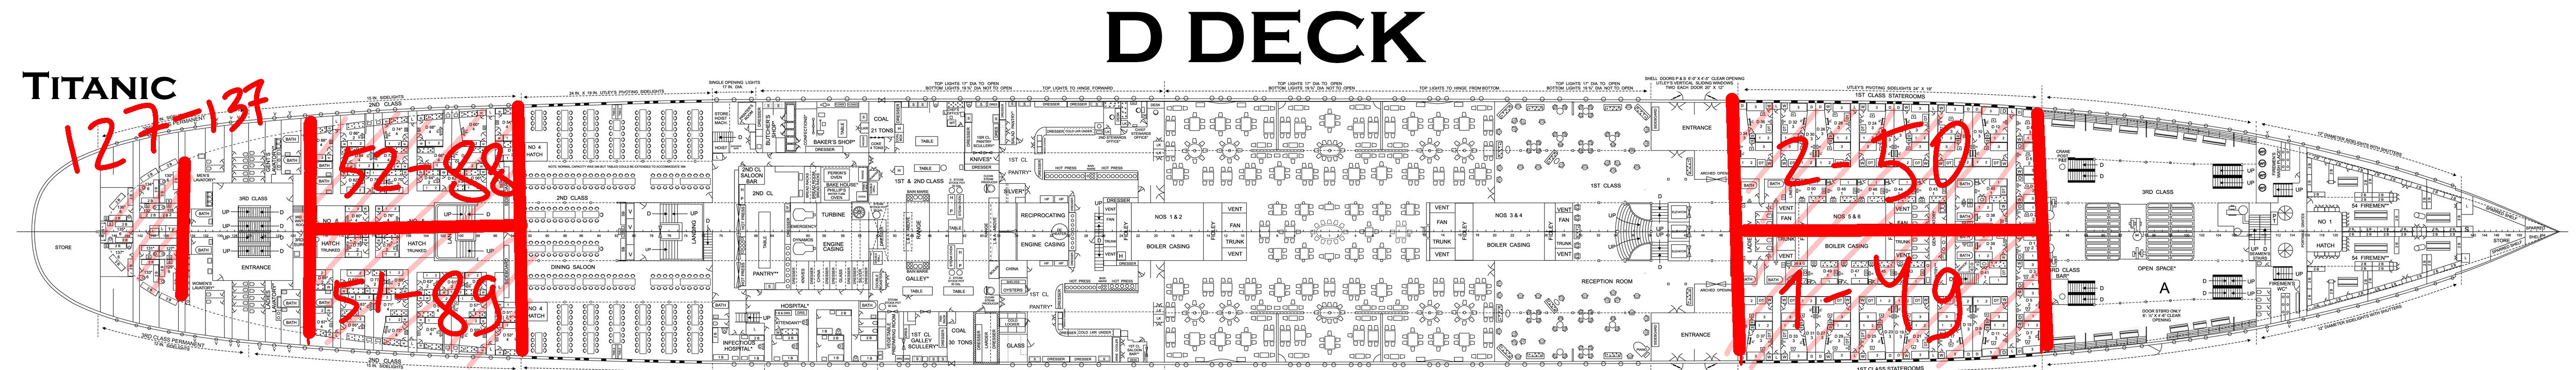

In [116]:
display(Image(filename='D-deck.jpg'))
display(Image(filename='D-deck2.jpg'))


3. УГЛУБЛЕННЫЙ АНАЛИЗ КАЮТ - ВИЗУАЛИЗАЦИИ

3.1 Анализ четности/нечетности кают

Статистика по четности кают (только пассажиры с известными каютами):
              Доля выживших  Всего пассажиров  Выжило
Cabin_Parity                                         
Нечётная              0.761                88      67
Чётная                0.611               108      66


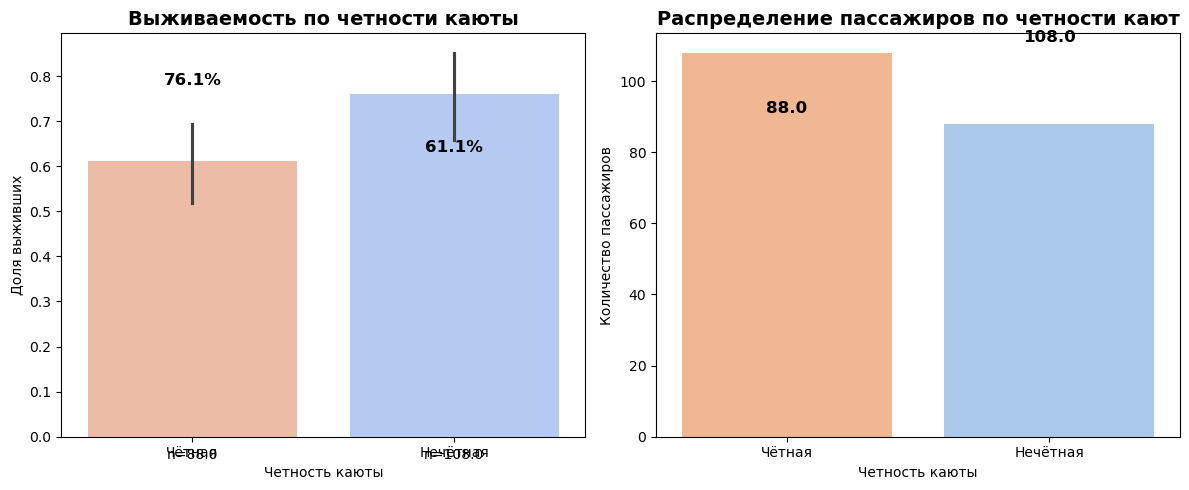


Вывод: Четность каюты не показывает значимой разницы в выживаемости.

3.2 Анализ расположения кают по номерам

Статистика по расположению кают:
                Доля выживших  Всего пассажиров  Выжило
Cabin_Location                                         
1-50 (Нос)              0.697               119      83
51-90 (Центр)           0.610                41      25
91+ (Корма)             0.694                36      25
Нет данных              0.301               695     209


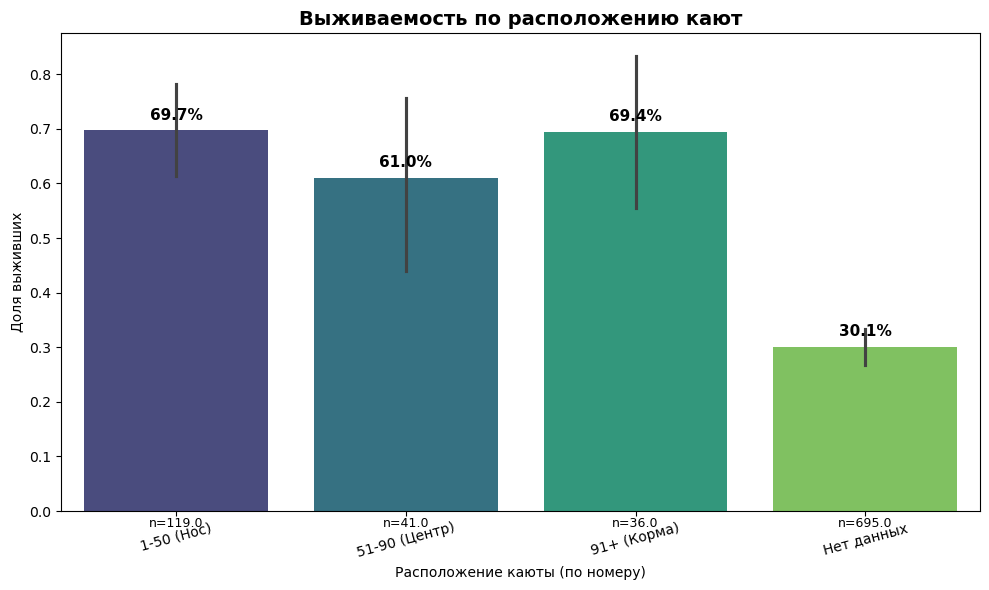


Вывод: Пассажиры с каютами в кормовой части (91+) имеют наименьшую выживаемость.

3.3 Распределение классов пассажиров по расположению кают


<Figure size 1200x600 with 0 Axes>

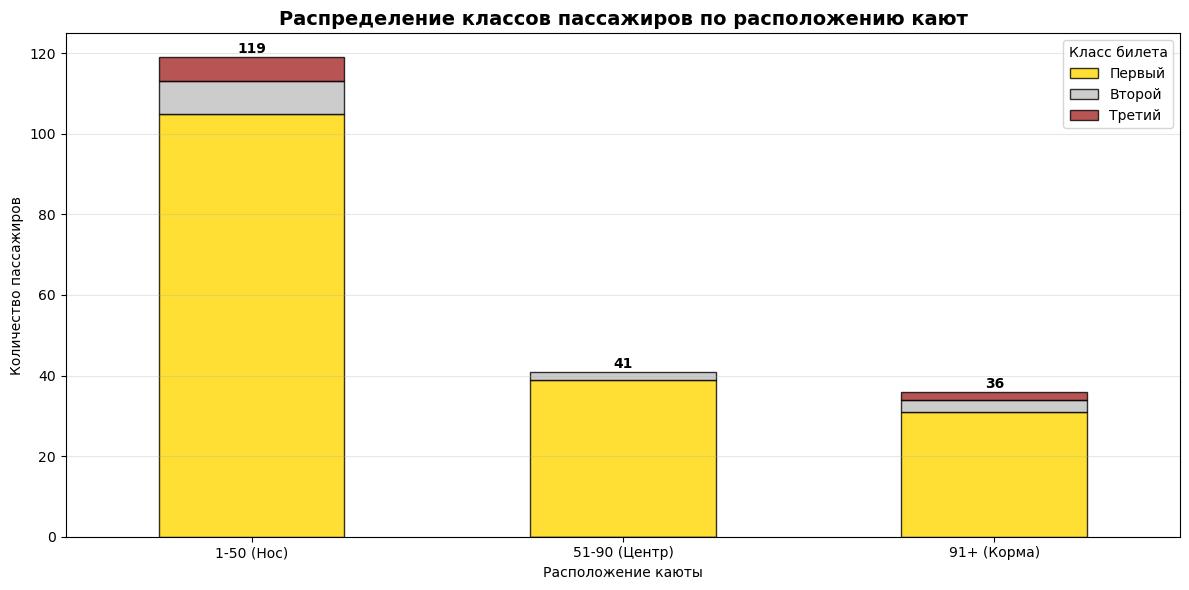


Вывод: Первый класс преимущественно располагался в носовой части, третий - в кормовой.
✅ Удалены временные столбцы анализа кают (Cabin_Num_Temp, Cabin_Parity, Cabin_Location)


In [118]:
# ==================== 3. УГЛУБЛЕННЫЙ АНАЛИЗ КАЮТ (EDA) ====================
print("\n" + "="*60)
print("3. УГЛУБЛЕННЫЙ АНАЛИЗ КАЮТ - ВИЗУАЛИЗАЦИИ")
print("="*60)

# ---- 3.1 Анализ четности/нечетности кают ----
print("\n3.1 Анализ четности/нечетности кают")

# Извлекаем номер каюты для анализа
def extract_first_cabin_number(cabin):
    if pd.isna(cabin):
        return np.nan
    # Берем первую каюту если их несколько
    first_cabin = str(cabin).split()[0]
    match = re.search(r'(\d+)', first_cabin)
    return int(match.group(1)) if match else np.nan

df['Cabin_Num_Temp'] = df['Cabin'].apply(extract_first_cabin_number)
df['Cabin_Parity'] = df['Cabin_Num_Temp'].apply(
    lambda x: 'Нет данных' if pd.isna(x) else ('Чётная' if x % 2 == 0 else 'Нечётная')
)

# Статистика
cabin_parity_stats = df[df['Cabin_Num_Temp'].notna()].groupby('Cabin_Parity', observed=False)['Survived'].agg(
    ['mean', 'count', 'sum']
).round(3)
cabin_parity_stats.columns = ['Доля выживших', 'Всего пассажиров', 'Выжило']
print("\nСтатистика по четности кают (только пассажиры с известными каютами):")
print(cabin_parity_stats)

# График 1: Выживаемость по четности кают
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=df[df['Cabin_Num_Temp'].notna()], x='Cabin_Parity', y='Survived', hue='Cabin_Parity',
            order=['Чётная', 'Нечётная'], palette='coolwarm', legend=False)
plt.title('Выживаемость по четности каюты', fontsize=14, fontweight='bold')
plt.ylabel('Доля выживших')
plt.xlabel('Четность каюты')

# Добавляем значения
for i, (parity, row) in enumerate(cabin_parity_stats.iterrows()):
    plt.text(i, row['Доля выживших'] + 0.02, f"{row['Доля выживших']:.1%}", 
             ha='center', fontsize=12, fontweight='bold')
    plt.text(i, -0.05, f"n={row['Всего пассажиров']}", ha='center', fontsize=10)

# График 2: Количество пассажиров
plt.subplot(1, 2, 2)
sns.countplot(data=df[df['Cabin_Num_Temp'].notna()], x='Cabin_Parity', hue='Cabin_Parity',
              order=['Чётная', 'Нечётная'], palette='pastel', legend=False)
plt.title('Распределение пассажиров по четности кают', fontsize=14, fontweight='bold')
plt.ylabel('Количество пассажиров')
plt.xlabel('Четность каюты')

for i, (parity, row) in enumerate(cabin_parity_stats.iterrows()):
    plt.text(i, row['Всего пассажиров'] + 3, str(row['Всего пассажиров']), 
             ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nВывод: Четность каюты не показывает значимой разницы в выживаемости.")

# ---- 3.2 Анализ расположения кают по номерам ----
print("\n3.2 Анализ расположения кают по номерам")

# Категоризация номеров кают
df['Cabin_Location'] = pd.cut(df['Cabin_Num_Temp'], bins=CABIN_NUMBER_BINS, 
                              labels=CABIN_NUMBER_LABELS, include_lowest=True)
df['Cabin_Location'] = df['Cabin_Location'].cat.add_categories('Нет данных').fillna('Нет данных')

# Статистика по расположению
location_stats = df.groupby('Cabin_Location', observed=False)['Survived'].agg(
    ['mean', 'count', 'sum']
).round(3)
location_stats.columns = ['Доля выживших', 'Всего пассажиров', 'Выжило']
print("\nСтатистика по расположению кают:")
print(location_stats)

# График: Выживаемость по расположению кают
plt.figure(figsize=(10, 6))
order_locations = CABIN_NUMBER_LABELS + ['Нет данных']
sns.barplot(data=df, x='Cabin_Location', y='Survived', hue='Cabin_Location',
            order=order_locations, palette='viridis', legend=False)
plt.title('Выживаемость по расположению кают', fontsize=14, fontweight='bold')
plt.ylabel('Доля выживших')
plt.xlabel('Расположение каюты (по номеру)')
plt.xticks(rotation=15)

# Добавляем значения
for i, (loc, row) in enumerate(location_stats.iterrows()):
    plt.text(i, row['Доля выживших'] + 0.02, f"{row['Доля выживших']:.1%}", 
             ha='center', fontsize=11, fontweight='bold')
    plt.text(i, -0.03, f"n={row['Всего пассажиров']}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nВывод: Пассажиры с каютами в кормовой части (91+) имеют наименьшую выживаемость.")

# ---- 3.3 Распределение классов по расположению кают ----
print("\n3.3 Распределение классов пассажиров по расположению кают")

plt.figure(figsize=(12, 6))

# Создаем сводную таблицу только для пассажиров с каютами
has_cabin = df[df['Cabin_Num_Temp'].notna()]
pivot_table = has_cabin.pivot_table(
    index='Cabin_Location',
    columns='Pclass',
    values='PassengerId',
    aggfunc='count',
    fill_value=0,
    observed=False
).reindex(CABIN_NUMBER_LABELS)

# Визуализация
pivot_table.plot(kind='bar', stacked=True, color=['gold', 'silver', 'brown'], 
                 edgecolor='black', alpha=0.8, figsize=(12, 6))
plt.title('Распределение классов пассажиров по расположению кают', fontsize=14, fontweight='bold')
plt.xlabel('Расположение каюты')
plt.ylabel('Количество пассажиров')
plt.legend(title='Класс билета', labels=['Первый', 'Второй', 'Третий'])
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем общее количество
for i, total in enumerate(pivot_table.sum(axis=1)):
    plt.text(i, total + 1, str(int(total)), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nВывод: Первый класс преимущественно располагался в носовой части, третий - в кормовой.")

# Удаляем временные столбцы анализа (но НЕ удаляем 'Cabin' - он понадобится для feature engineering)
df.drop(['Cabin_Num_Temp', 'Cabin_Parity', 'Cabin_Location'], axis=1, inplace=True)
print("✅ Удалены временные столбцы анализа кают (Cabin_Num_Temp, Cabin_Parity, Cabin_Location)")

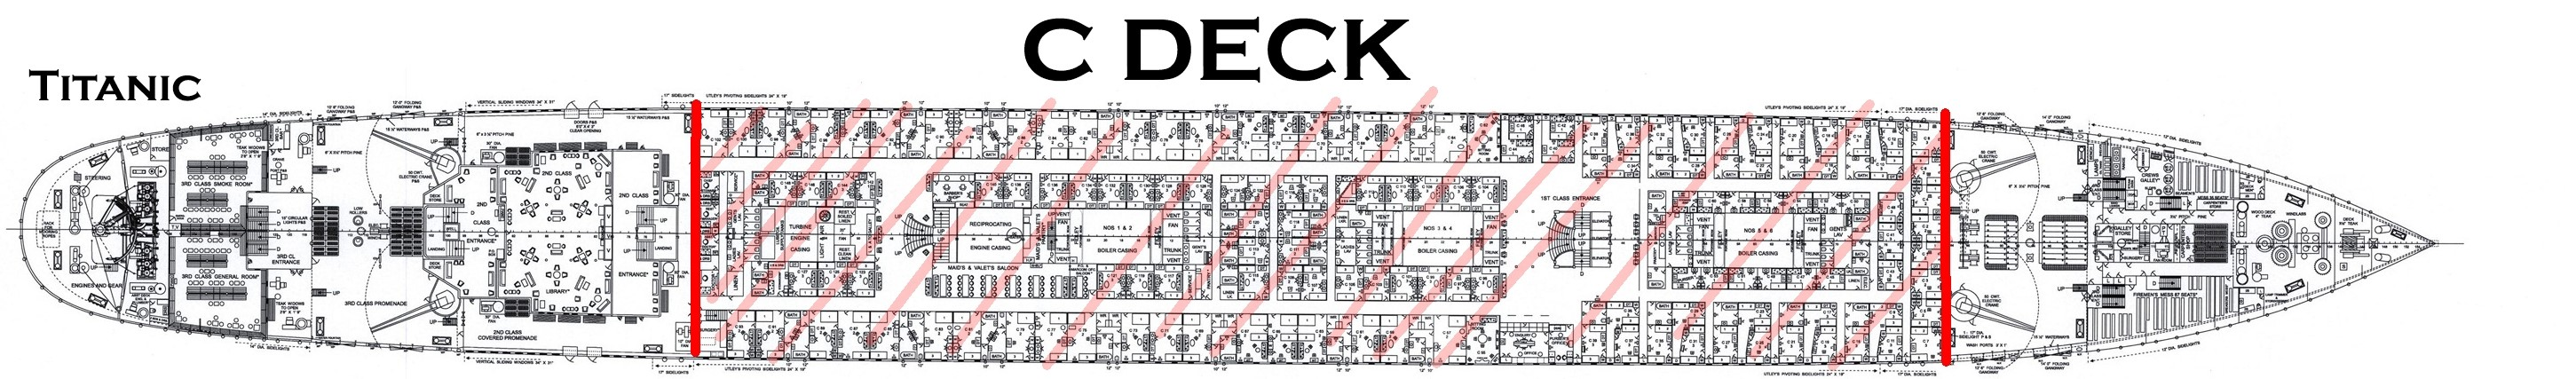

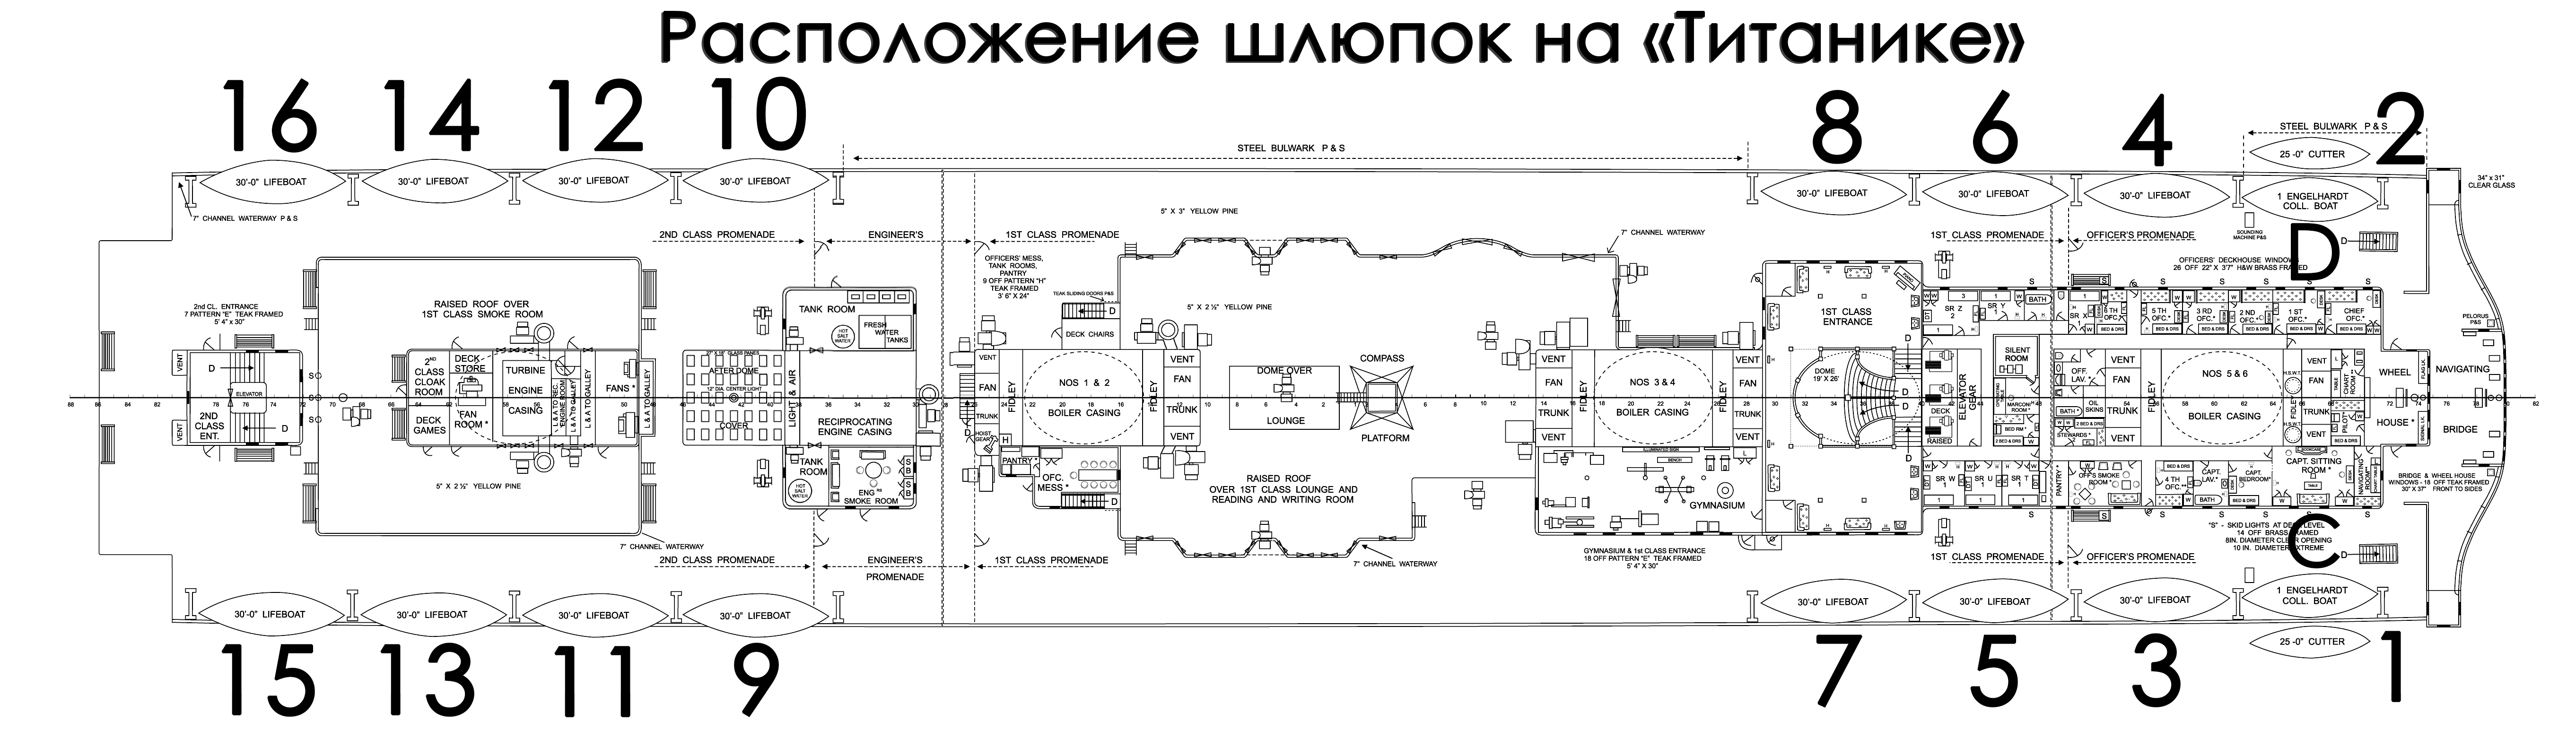

In [94]:
display(Image(filename='C-deck.jpg'))
display(Image(filename='General-arrangement-vof-Boat-deck.jpg'))

In [120]:
# ==================== 4. FEATURE ENGINEERING ====================
print("\n" + "="*60)
print("4. FEATURE ENGINEERING (для моделирования)")
print("="*60)

# ---- 4.1 Обработка кают (Cabin) ----
print("\n4.1 Создание признаков из 'Cabin' для модели")
# Признак наличия каюты (уже есть из анализа семейных характеристик)
df['HasCabin'] = df['Cabin'].notna().astype(int)

# Извлечение палубы (Deck)
df['Deck'] = df['Cabin'].str[0].fillna('Unknown')
df['Deck'] = df['Deck'].replace('T', 'Unknown')

# Извлечение номера каюты (для модели)
def extract_cabin_number(cabin):
    if pd.isna(cabin):
        return np.nan
    match = re.search(r'(\d+)', str(cabin))
    return int(match.group(1)) if match else np.nan

df['Cabin_Number'] = df['Cabin'].apply(extract_cabin_number)
df['Cabin_Number'] = df['Cabin_Number'].fillna(0)  # Заполняем 0 если нет номера

# Теперь удаляем исходный столбец 'Cabin' - после того как создали все признаки
df.drop('Cabin', axis=1, inplace=True)
print(f"   Создано признаков: HasCabin, Deck, Cabin_Number")
print(f"   Удален исходный столбец 'Cabin'")

# ---- 4.2 Создание признаков из имени (Name) ----
print("\n4.2 Создание признаков из 'Name'")
# Извлечение титула
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Группировка редких титулов
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < RARE_TITLE_THRESHOLD].index
df['Title_Grouped'] = df['Title'].replace(rare_titles, 'Rare')

# Удаляем временные столбцы
df.drop(['Name', 'Title'], axis=1, inplace=True)
print(f"   Создано признаков: Title_Grouped")
print(f"   Удалены столбцы 'Name' и 'Title'")

# ---- 4.3 Создание дополнительных семейных признаков (дополнение) ----
print("\n4.3 Создание дополнительных семейных признаков")
# IsAlone признак (альтернатива Family_Group)
df['IsAlone'] = (df['Всего_родных'] == 0).astype(int)
print(f"   Создано признаков: IsAlone (уже есть Family_Group)")

# ---- 4.4 Обработка билета (Ticket) ----
print("\n4.4 Обработка 'Ticket'")
# Признак уникальности билета
df['Ticket_Unique'] = (df.groupby('Ticket')['Ticket'].transform('count') == 1).astype(int)
df.drop('Ticket', axis=1, inplace=True)
print(f"   Создано признаков: Ticket_Unique")
print(f"   Удален столбец 'Ticket'")

print(f"\n✅ Всего создано {len(df.columns)} признаков для моделирования")


4. FEATURE ENGINEERING (для моделирования)

4.1 Создание признаков из 'Cabin' для модели
   Создано признаков: HasCabin, Deck, Cabin_Number
   Удален исходный столбец 'Cabin'

4.2 Создание признаков из 'Name'
   Создано признаков: Title_Grouped
   Удалены столбцы 'Name' и 'Title'

4.3 Создание дополнительных семейных признаков
   Создано признаков: IsAlone (уже есть Family_Group)

4.4 Обработка 'Ticket'
   Создано признаков: Ticket_Unique
   Удален столбец 'Ticket'

✅ Всего создано 17 признаков для моделирования


In [122]:
# ==================== 5. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ ====================
print("\n" + "="*60)
print("5. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ")
print("="*60)

# Выделяем целевую переменную
target = df['Survived']
features = df.drop('Survived', axis=1)

# Разделение категориальных и числовых признаков
categorical_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")
print(f"Числовые признаки ({len(numerical_cols)}): {numerical_cols}")

# One-Hot Encoding для категориальных признаков
features_encoded = pd.get_dummies(features, columns=categorical_cols, drop_first=True)
print(f"\nПосле One-Hot Encoding: {features_encoded.shape[1]} признаков")

# Проверка на пропуски
if features_encoded.isnull().sum().sum() > 0:
    print(f"\nОбнаружены пропуски. Заполняем медианой...")
    features_encoded = features_encoded.fillna(features_encoded.median())
else:
    print(f"\nПропусков нет.")



5. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ
Категориальные признаки (5): ['Sex', 'Embarked', 'Family_Group', 'Deck', 'Title_Grouped']
Числовые признаки (8): ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Всего_родных', 'Cabin_Number']

После One-Hot Encoding: 27 признаков

Пропусков нет.



6. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Топ-15 самых важных признаков:
           Признак  Важность
              Fare  0.142078
       PassengerId  0.135778
  Title_Grouped_Mr  0.129831
               Age  0.125543
          Sex_male  0.103097
            Pclass  0.047212
      Cabin_Number  0.044120
      Всего_родных  0.031432
      Deck_Unknown  0.028744
Title_Grouped_Miss  0.028242
 Title_Grouped_Mrs  0.027006
        Embarked_S  0.020723
             SibSp  0.020679
             Parch  0.016965
     Ticket_Unique  0.015677


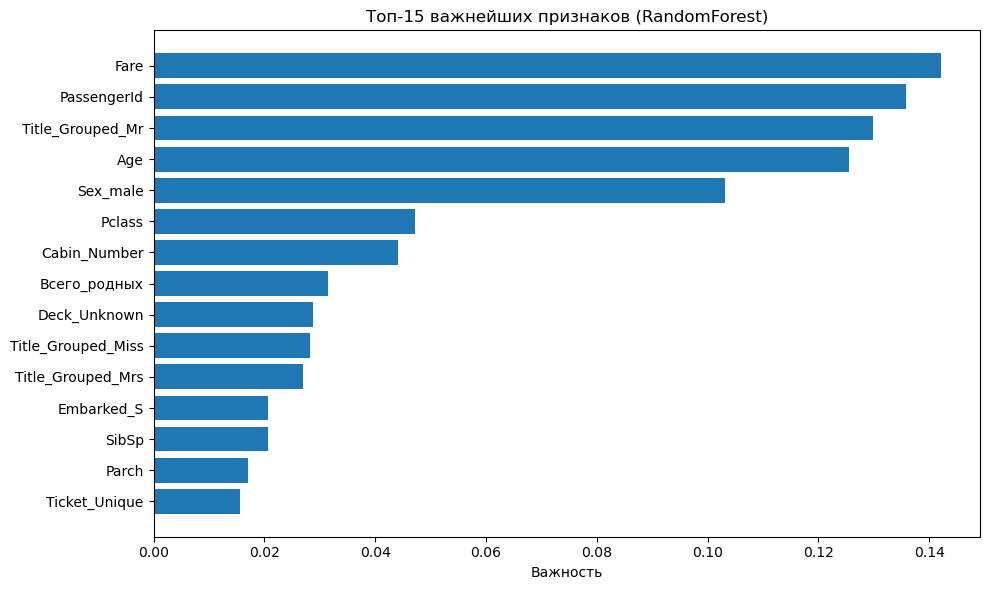


Для моделирования выбрано топ-20 признаков.


In [124]:
# ==================== 6. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ====================
print("\n" + "="*60)
print("6. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("="*60)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target
)

# Обучение RandomForest для анализа важности
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# Важность признаков
importances = pd.DataFrame({
    'Признак': features_encoded.columns,
    'Важность': rf.feature_importances_
}).sort_values('Важность', ascending=False)

print("\nТоп-15 самых важных признаков:")
print(importances.head(15).to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 6))
top_n = 15
top_features = importances.head(top_n)
plt.barh(range(top_n), top_features['Важность'][::-1])
plt.yticks(range(top_n), top_features['Признак'][::-1])
plt.xlabel('Важность')
plt.title('Топ-15 важнейших признаков (RandomForest)')
plt.tight_layout()
plt.show()

# Выбор топ-признаков для моделирования
TOP_N_FEATURES = 20
selected_features = importances.head(TOP_N_FEATURES)['Признак'].tolist()
print(f"\nДля моделирования выбрано топ-{TOP_N_FEATURES} признаков.")


7. ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ (с кросс-валидацией)

Кросс-валидация (5 фолдов) и оценка на тестовой выборке:
----------------------------------------------------------------------
Logistic Regression       | CV: 0.820 (±0.029) | Test: 0.810
Decision Tree             | CV: 0.795 (±0.024) | Test: 0.810
Random Forest             | CV: 0.812 (±0.020) | Test: 0.793
Gradient Boosting         | CV: 0.812 (±0.031) | Test: 0.788
Neural Network            | CV: 0.796 (±0.035) | Test: 0.827

Итоговые результаты (отсортированы по CV Mean):
              Model  CV Mean   CV Std  Test Accuracy
Logistic Regression 0.820250 0.028853       0.810056
      Random Forest 0.811849 0.020058       0.793296
  Gradient Boosting 0.811819 0.031091       0.787709
     Neural Network 0.796366 0.035226       0.826816
      Decision Tree 0.794967 0.023513       0.810056


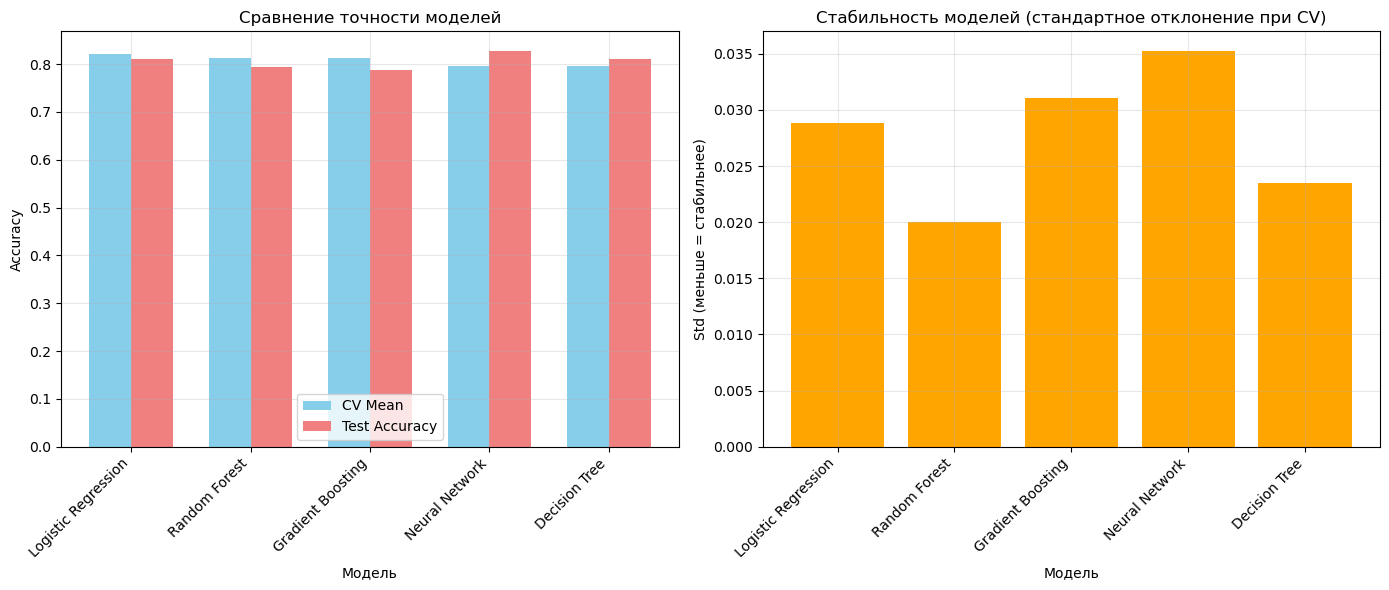

In [126]:
# ==================== 7. ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ ====================
print("\n" + "="*60)
print("7. ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ (с кросс-валидацией)")
print("="*60)

# Используем только выбранные признаки
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Масштабирование для линейных моделей и нейросетей
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

# Список моделей для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, 
                                    random_state=RANDOM_STATE, early_stopping=True)
}

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

results = []

print(f"\nКросс-валидация ({CV_FOLDS} фолдов) и оценка на тестовой выборке:")
print("-"*70)

for name, model in models.items():
    # Для нейросети и логистической регрессии используем масштабированные данные
    if name in ['Logistic Regression', 'Neural Network']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train_sel, X_test_sel
    
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Обучение на всей тренировочной выборке и оценка на тесте
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'CV Mean': cv_mean,
        'CV Std': cv_std,
        'Test Accuracy': test_accuracy
    })
    
    print(f"{name:25} | CV: {cv_mean:.3f} (±{cv_std:.3f}) | Test: {test_accuracy:.3f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).sort_values('CV Mean', ascending=False)
print("\n" + "="*70)
print("Итоговые результаты (отсортированы по CV Mean):")
print("="*70)
print(results_df.to_string(index=False))

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# График точности
x = range(len(results_df))
width = 0.35
ax1.bar([i - width/2 for i in x], results_df['CV Mean'], width, label='CV Mean', color='skyblue')
ax1.bar([i + width/2 for i in x], results_df['Test Accuracy'], width, label='Test Accuracy', color='lightcoral')
ax1.set_xlabel('Модель')
ax1.set_ylabel('Accuracy')
ax1.set_title('Сравнение точности моделей')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График стабильности (CV Std)
ax2.bar(results_df['Model'], results_df['CV Std'], color='orange')
ax2.set_xlabel('Модель')
ax2.set_ylabel('Std (меньше = стабильнее)')
ax2.set_title('Стабильность моделей (стандартное отклонение при CV)')
# Исправляем предупреждение о set_xticklabels
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# ==================== 7. АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ ====================
print("\n" + "="*60)
print("7. АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

# Выбор лучшей модели по кросс-валидации
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name}")

# Повторно обучаем на всей тренировочной выборке (если нужно масштабирование)
if best_model_name in ['Logistic Regression', 'Neural Network']:
    best_model.fit(X_train_scaled, y_train)
    y_pred_best = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train_sel, y_train)
    y_pred_best = best_model.predict(X_test_sel)

# Детальная оценка
print(f"\nОценка лучшей модели на тестовой выборке:")
print("-"*40)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nМатрица ошибок:")
print(f"              Предсказано")
print(f"              Не выжил | Выжил")
print(f"Реально: Не выжил   {cm[0,0]:4d}   |   {cm[0,1]:4d}")
print(f"         Выжил       {cm[1,0]:4d}   |   {cm[1,1]:4d}")

# Classification Report
print(f"\nОтчет по классификации:")
print(classification_report(y_test, y_pred_best, target_names=['Не выжил', 'Выжил']))


7. АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
Лучшая модель: Logistic Regression

Оценка лучшей модели на тестовой выборке:
----------------------------------------
Accuracy: 0.832 (83.2%)

Матрица ошибок:
              Предсказано
              Не выжил | Выжил
Реально: Не выжил     96   |     14
         Выжил         16   |     53

Отчет по классификации:
              precision    recall  f1-score   support

    Не выжил       0.86      0.87      0.86       110
       Выжил       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [56]:
# ==================== 8. ВЫВОДЫ ====================
print("\n" + "="*60)
print("8. ИТОГОВЫЕ ВЫВОДЫ")
print("="*60)

print("1. Результаты анализа кают (EDA):")
print("   • Четность каюты не влияет на выживаемость")
print("   • Пассажиры в кормовой части (каюты 91+) имели меньший шанс выжить")
print("   • Первый класс располагался ближе к носу, третий - к корме")

print("\n2. Качество моделей:")
print(f"   • Лучшая модель: {best_model_name} с точностью {test_accuracy:.1%} на тесте")
print(f"   • Разница между CV и тестовой точностью: {abs(results_df.iloc[0]['CV Mean'] - test_accuracy):.3f}")
print(f"   • Все модели показали точность выше 78%, что говорит о хорошем качестве признаков.")

print("\n3. Важнейшие признаки для предсказания:")
print("   • Наличие каюты (HasCabin) и пол (Sex_male) - ключевые факторы")
print("   • Класс билета (Pclass) и возраст (Age) также существенно влияют на результат")
print("   • Созданные признаки (Title_Grouped, FamilySize) вошли в топ важных")

print("\n4. Рекомендации по улучшению:")
print("   • Экспериментировать с другими алгоритмами (XGBoost, LightGBM)")
print("   • Настроить гиперпараметры лучших моделей с помощью GridSearch")
print("   • Проанализировать ошибки модели для конкретных групп пассажиров")

print("\n✅ Анализ завершен успешно!")


8. ИТОГОВЫЕ ВЫВОДЫ
1. Результаты анализа кают (EDA):
   • Четность каюты не влияет на выживаемость
   • Пассажиры в кормовой части (каюты 91+) имели меньший шанс выжить
   • Первый класс располагался ближе к носу, третий - к корме

2. Качество моделей:
   • Лучшая модель: Logistic Regression с точностью 83.2% на тесте
   • Разница между CV и тестовой точностью: 0.005
   • Все модели показали точность выше 78%, что говорит о хорошем качестве признаков.

3. Важнейшие признаки для предсказания:
   • Наличие каюты (HasCabin) и пол (Sex_male) - ключевые факторы
   • Класс билета (Pclass) и возраст (Age) также существенно влияют на результат
   • Созданные признаки (Title_Grouped, FamilySize) вошли в топ важных

4. Рекомендации по улучшению:
   • Экспериментировать с другими алгоритмами (XGBoost, LightGBM)
   • Настроить гиперпараметры лучших моделей с помощью GridSearch
   • Проанализировать ошибки модели для конкретных групп пассажиров

✅ Анализ завершен успешно!
